# Newton's Method for Optimization in Python 

## Introduction

We will implement Newton's Method, a second order optimization algorithm from scratch in python. Given a real valued function $f(x)$, the goal is to find number(s) $c$ such that $f'(c) = 0.$ Suppose we have a function $f: \mathbb{R} \to \mathbb{R}$, the Newton's metod gives us a itterative algorith to find the zero's of f(x). In particular, the itterative formula for finding $x^*$ such that f($x^*$) = 0 is 
\begin{equation}
x_{t+1} = x_t - \frac{f(x_t)}{f'(x_t)},
\end{equation}

where $t$ is the itteration index. As $t$ gets very large, it turns out that $x_{t+1}$ will get very close to $x_{t}$ and converge towards $x^*$. 

## Intuition behind Newton's method formula
Again let's suppose $f: \mathbb{R} \to \mathbb{R},$ and $f(x^*) = 0.$ We can approximate $f(x)$ at $x^*$ using the taylor series expansion, that is $$f(x^*) \approx f(x) + f'(x)(x^*-x).$$ Now since $f(x^*) = 0,$ we can rearrage the above equation and get $$x^* \approx x - \frac{f(x)}{f'(x)},$$ if $x$ is somewhat close to $x^*$ this suggests the itterative Newton's method can find the zeros of $f(x).$

## Application of Newton's method to IMDB movie data
Now that we have a basic sense of the newton's method, we will use to estimate the parameters in a linear regression framework to model the relationship between IMDB's movies score (rating out of 10) and the movies gross sales (in dollars). We will use a data set from https://www.kaggle.com/deepmatrix/imdb-5000-movie-dataset. The data contains various statistics from IMDB for over 5000 movies. For our purposes we will only be interested in the IMDB rating and gross sales.

In [38]:
# Import the standard packages for doing math operations, data manipulation, and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
# Load the IMDB data
movie_data = pd.read_csv("movie_metadata.csv")

# Show all the variables in the data set
movie_data.columns.values

array(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'], dtype=object)

Let's clean the data set a little bit. We will only keep the US movies since some of the gross revenues for movies from other countries are not reported in dollars. We will also only keep the imdb score and gross revenue variables for our analysis and drop the rest. I also informally convert the movie gross sales revenue in terms of 2017 dollar by assuming a $2.5\%$ yearly inflation rate. (To formally convert to 2017 dollars we would need to use consumer price index data from the US bureau of labour statistics)

In [40]:
# Only keep data on movies from the US
movie_data = movie_data[movie_data['country'] == "USA"]

# Assuming a average US inflation rate of 2.5%, we convert gross revenue in terms of 2017 dollars
movie_data[['gross']] = (1.025**(2017-movie_data['title_year']))*movie_data['gross']

# Only keep the variables of interest, 'imdb_score' and 'gross'
movie_data = movie_data[['gross','imdb_score']]

# Let's scale the gross revenue to be in millions of dollars so its easier to read
movie_data[['gross']] = movie_data[['gross']]/1000000

# Summary statistics
movie_data.describe()

,gross,imdb_score
count,3235.000000,3807.000000
mean,79.764661,6.367428
std,109.842143,1.125015
min,0.001044,1.600000
25%,14.132349,5.700000
50%,44.210734,6.500000
75%,102.207258,7.100000
max,1363.206376,9.300000


From the above summary statistics, we notice the average IMDB US movie rating is 6.4, and average gross sales revenue is about 80 million.

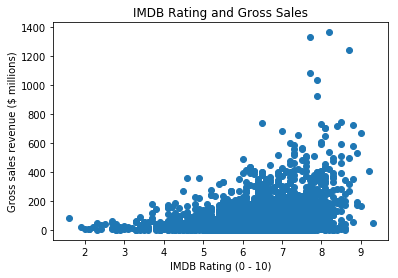

In [42]:
# Visualize data
plt.scatter(movie_data['imdb_score'], movie_data['gross'])

# Chart title
plt.title('IMDB Rating and Gross Sales')

# y label
plt.ylabel('Gross sales revenue ($ millions)')

# x label
plt.xlabel('IMDB Rating (0 - 10)')

plt.show()

## Linear regression model
We want to fit a "line of best fit" to the above scatter plot. In particular, we want to model the relationship between IMDB rating and gross movie sales as $$GrossSales_{i} = \beta_{0} + \beta_{1}IMDBRating_{i} + \epsilon_{i},$$ where $\epsilon_{i}$ is a random error term with mean 0. We would like to estimate values for $\beta = (\beta_1, \beta_2)$ that "best fits" the data. To define fitness, we will use the square loss function. That is the sum of square error is $$SSE = \frac{1}{2n}\sum_{i=1}^{n} (GrossSales_{i} - \hat{GrossSales_{i}})^2,$$ where $\hat{GrossSales_{i}}$ is the predicted gross revenue of movie $i$ from our linear model. More precisely, $$\hat{GrossSales_{i}} = \hat{\beta_{0}} + \hat{\beta_{1}}IMDBRating_{i}.$$ The basic idea here is that we want to chose $\hat{\beta} = (\hat{\beta_1}, \hat{\beta_2})$ so that SSE is small as possible and that will be resulting "line of best fit"

# Newton's method for linear regression model